# Pokemon Convolution

This Jupyter Notebook will explore predicting information about a Pokemon based on their sprite. 

Steps:
1) WebScrape together a dataset of Pokemon images

2) Develop and Train a convolutional model to classify Pokemon by their type

3) Develop and Train a regression model to predict the stats of a Pokemon

4) Put it all together into a single function that plots the sprite and model predictions agaisnt the ground truth




In [1]:
import os
import json
import requests
from bs4 import BeautifulSoup
import urllib3
import shutils
import tqdm
import random
import PIL

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory

Define a buildDatabase function to import all the pokemon name, typings, and a link to download their sprite and store it in a Pandas DataFrame. Thanks to Pokemondb.net!

In [2]:
def buildDatabase(url):
    
    # Pull in the url's html
    webpage = requests.get(url)
    
    # Use Beautiful Soup to parse through the html
    soup = BeautifulSoup(webpage.content, "html.parser")
    
    # Navigate the soup datastructure to sort through each pokemon to pull its information
    typing_list = []
    for entry in soup.find_all("div", class_="infocard"):
        
        # Identify the Pokemon's name and typing
        pokemon = entry.find_all("a", class_ = True)
        for i, item in enumerate(pokemon):
            
            # Record the name
            item = item["href"].split("/")
            if item[1] == 'pokedex':
                name = item[2]
            
            # Record the typing
            if item[1] =='type':
                typing = item[2]
                typing_list.append(typing)
                
        # Handle dual and single typing
        if len(typing_list) == 2:
            typing1 = typing_list[0]
            typing2 = typing_list[1]
            typing_list = []
        if len(typing_list) == 1:
            typing1 = typing_list[0]
            typing2 = "None"
            typing_list = []
        
        # End Pokemon collection after this point due to change in sprite quality
        if name =="meltan":
            break
        
        # Identify the Pokemon's sprites image link  
        link = entry.find("span", class_="img-fixed img-sprite")
        link = link["data-src"]
        
        # Store the Pokemon's information in the DataFrame
        entry_dict = {'Pokemon':name,
                     'Type 1' : typing1,
                     'Type 2' : typing2,
                     'ImageLink' : link}
      
        if name != 'bulbasaur':
            pokemonDataFrame = pokemonDataFrame.append(entry_dict, ignore_index=True)
        else:
            pokemonDataFrame = pd.DataFrame(data=entry_dict, index=[0])
    
    # With a list of all of the pokemon, we will have to use another website to gather all of their stats
    hp = []
    attack = []
    defense = []
    sp_attack = []
    sp_defense = []
    speed = []
    
    # Cycle through the seperate website for each pokemon
    for i in range(len(pokemonDataFrame)):
        
        # Define Pokemon specific website url
        url = 'https://pokemondb.net/pokedex/' +  pokemonDataFrame["Pokemon"][i]
        
        # Pull in the url's html
        webpage = requests.get(url)

        # Use Beautiful Soup to parse through the html
        soup = BeautifulSoup(webpage.content, "html.parser")
        
        # Sort through to find the append the base stat to the list
        for j, stat in enumerate(soup.find_all("td", class_="cell-num")):
            if j == 0:
                hp.append(stat.text)
            if j == 3:
                attack.append(stat.text)
            if j == 6:
                defense.append(stat.text)
            if j == 9:
                sp_attack.append(stat.text)
            if j == 12:
                sp_defense.append(stat.text)
            if j == 15:
                speed.append(stat.text)
    
    # Create a Data Frame with the stats and attach it to the existing Data Frame
    stats_dict = {'HP': hp,
            'Attack' : attack,
            'Defense' : defense,
            'Special Attack' : sp_attack,
            'Special Defense' : sp_defense,
            'Speed' : speed,}
    
    # Create the stats Data Frame
    statsDatatFrame = pd.DataFrame(data=stats_dict)
    
    # Attach it to the existing Data Frame
    pokemonDataFrame = pd.concat([pokemonDataFrame, statsDatatFrame], axis=1)        
    
    return pokemonDataFrame



Let's run the function to create our DataFrame and check out an entry.

In [3]:
pokemonDataFrame = buildDatabase('https://pokemondb.net/pokedex/national')
print(pokemonDataFrame.iloc[156])

Pokemon                                                   typhlosion
Type 1                                                          fire
Type 2                                                          None
ImageLink          https://img.pokemondb.net/sprites/bank/normal/...
HP                                                                78
Attack                                                            84
Defense                                                           78
Special Attack                                                   109
Special Defense                                                   85
Speed                                                            100
Name: 156, dtype: object


Now that we have a Data Frame with all of the pokemon we plan to train and test our model with, we need to go through and download the sprite image for each pokemon and save it to a local folder. I started by webscrapping all of the images from the most recent generation, which resulted in ~800 training examples for 20 different classes. The thinking was that higher resolution training examples would provide better training data; however, that decision proved poor. It was challenging to train the model with that few training examples, so I went back and downloaded more from older generations to have closer to 6k training examples.  To further augment the data, the convolutional model included a random horizontal flip and a random rotation. Images of the current training dataset can be seen below Images are saved based on their classification, which will allow TensorFlow to load the entire Dataset, both input and classification, in with one command.

In [4]:
def spriteDownloaderwithType(df):

    # Go down each entry of the dataframe and save the sprite's image from the "ImageLink" column
    for i in range(len(df)):
        
        # Pull the url and define the save path
        url = df["ImageLink"].iloc[i]
        filename = url.split("/")[-1]
        
        # Only handling primary typing           
        typing = df["Type 1"].iloc[i]
                
        # Determine Directory to save photo
        path = os.getcwd() + "\PokemonSprites\\" + typing + "\\"
        
        # Check if the correct path already exists
        if os.path.isdir(path):
            
            # Save photo
            response = requests.get(url)
            with open(path+filename, 'wb') as local_file:
                local_file.write(response.content)
                
         # Create the path if necessary
        else:
            new_directory = typing
            directory = os.getcwd() + "\PokemonSprites\\"
            directory = os.path.join(directory, new_directory)
            os.mkdir(directory)
            
            # Save photo
            response = requests.get(url)
            with open(path+filename, 'wb') as local_file:
                local_file.write(response.content)               


In [5]:
spriteDownloaderwithType(pokemonDataFrame)

At this point, we have collected all of the data to train and test our model. All of the images are stored in a local folder. Let's start by defining the image size and datasets(train/dev/test).

In [6]:
# Define tf.Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (128,128)
IMG_SHAPE = (128,128,3)

# Define file path
directory = os.getcwd() + "\\cleaned_train"
seed = 107

# Load in the training set, while allocating 20% for validation
train_dataset = image_dataset_from_directory(directory,
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            validation_split=0.2,
                                            subset="training",
                                            label_mode='categorical',
                                            seed=seed)

validation_dataset = image_dataset_from_directory(directory,
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            validation_split=0.2,
                                            subset="validation",
                                            label_mode='categorical',
                                            seed=seed)

# Load in the test set
directory = os.getcwd() + "\\cleaned_test"
test_dataset = image_dataset_from_directory(directory,
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            label_mode='categorical')



Found 4569 files belonging to 18 classes.
Using 3656 files for training.
Found 4569 files belonging to 18 classes.
Using 913 files for validation.
Found 1013 files belonging to 18 classes.


Now let's take a look at some of the images from the training set: 

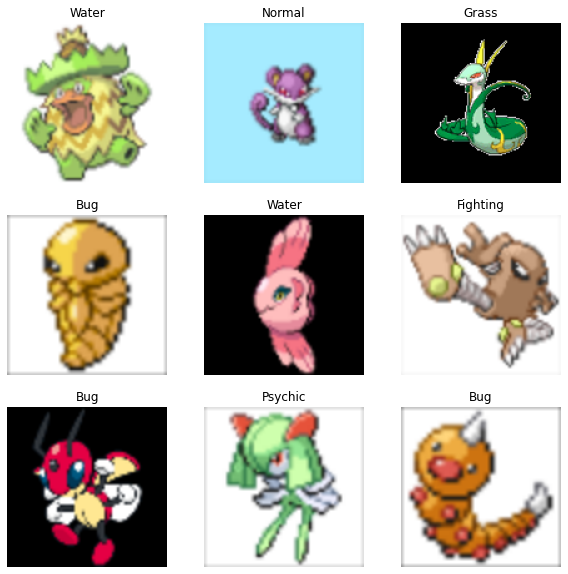

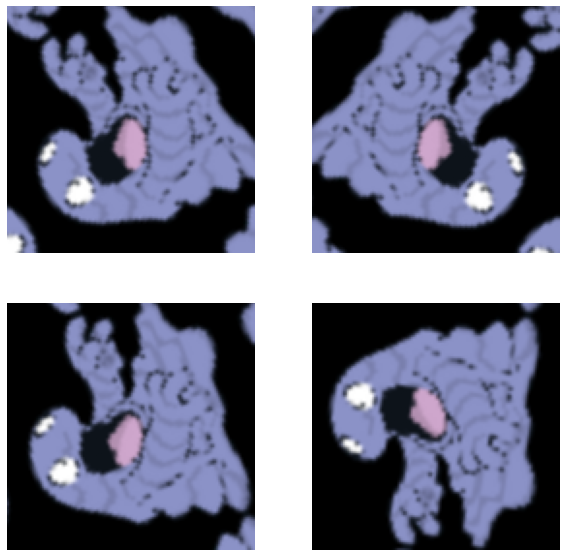

In [7]:
# Pull the labels from tf.Dataset
classNames = train_dataset.class_names

# Take a look at the training images
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = tf.math.argmax(labels[i,:])
        plt.title(classNames[title])
        plt.axis("off")

# Define a data augmentation function to use on images
def data_augmenter():

    # Create keras data augmentation model to flip and rotate images
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.5))

    return data_augmentation

data_augmentation = data_augmenter()

# Take a look at how the data_augmenter looks on an entry
for image, _ in train_dataset.take(1): 
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')



The training data looks sufficient at this point. Now, we can look at developing the convolutional model. Given the size of the dataset and that Pokémon type recognition seemed akin to classifying animals at a zoo, transfer learned from readily available pre-trained networks seemed like an auspicious path. To optimize the model selection process, I parameterized the model to consider different number of fully connected layers,  dropout rates, nodes per layer, and how many layers of the original model to freeze. Then, a script would facilitate creating, training, and ranking models within the parameterized design space. For a project without that many training examples and relatively few trainable parameters, this allowed for a wide variety of models to quickly be considered.  Ultimately, I arrived at a validation set and test set accuracy of ~62%. 

In [8]:
#Define a parameterized transfer learning model
def TuneModel(fc_layers,  dropout_rate, fc_nodes, tune_layers, input_shape = IMG_SHAPE, outputs=classNames):
    
    # Download a Pre-trained MobileNet from Tensorflow
    preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   classifier_activation = "softmax",
                                                   weights='imagenet')

    
    # Define inputs
    inputs = tf.keras.Input(shape = input_shape)
    
    # Use MobileNet Preprocessing
    x = preprocessing(inputs)
    
    # Include Data augmentation
    x = data_augmentation(x)
        
   # Freeze the base model, as we only want to tune the base model by training the added layers at the end
    base_model.trainable = False
    if tune_layers > 0:
        freeze_count = int(len(base_model.layers) - tune_layers)      
        for layer in base_model.layers[freeze_count:]:
            layer.trainable = True
    
    # Set training to False
    x = base_model(x)
    
    # Add a convolutional layers at the end
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Add some fully connected layers at the end
    if fc_layers > 0:
        for i in range(fc_layers):
            x = tf.keras.layers.Dense(units = fc_nodes, activation = "relu",
                                      kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))(x)
            x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    
    # Add a softmax layer at the end for predicting type
    output_size = len(outputs)
    prediction_layer = tf.keras.layers.Dense(units = output_size, activation = "softmax", kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))
    
    # Define outputs and model
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model



# Define a function that takes a list of parameters for the TuneModel and tries random combinations 
def Tuner(fc_layers,  dropout_rate, fc_nodes, tune_layers, iterations):
    
    # Initiate output dictionary
    output = {}
    
    # Setup callbacks to stop unauspicous combinatoins from completing all epochs and stop models once overfitting occurs
    stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                patience=2, 
                                                min_delta=0.001, 
                                                mode='max')
    
    #Consider random combinations
    for i in range(iterations):
        fc_l = fc_layers[random.randint(0,len(fc_layers) - 1)]
        d_r = dropout_rate[random.randint(0,len(dropout_rate) - 1)]
        fc_n = fc_nodes[random.randint(0,len(fc_nodes) - 1)]
        t_l = tune_layers[random.randint(0,len(tune_layers) - 1)]
        
        
        #Compile Model
        model_i = TuneModel(fc_l,  d_r, fc_n, t_l)
        model_i.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

                    
                    
        #Train Model
        history = model_i.fit(train_dataset, epochs = 15, shuffle=True, validation_data = validation_dataset, 
                              callbacks=[stopping],verbose = 0)
                    
        # Document the model just run
        model = (str(fc_l) +', '+ str(d_r) +', '+ str(fc_n) +', '+ str(t_l))
        model_acc = [history.history['accuracy'][-1], history.history['val_accuracy'][-1]]

        print(model)
        print(model_acc)
                    
        # Store model to output dictionary
        output.update({model: model_acc})
    return output

In [15]:
#Here are the model parameters we will first attempt to consider
c_layers =[0,1,3,5]
ropout_rate = [.1, .3, .5, .8]
c_nodes = [20, 50, 100, 500]
tune_layers = [0, 3, 5]

#uneRuns = Tuner(fc_layers,  dropout_rate, fc_nodes, tune_layers, 10)

# Store the saved runs and print them sorted by accuracy to further refine tuning criteria
output = TuneRuns
out = sorted(output.items(), key=lambda x: x[1])
print(out)

[('5, 0.5, 20, 3', [0.14715535938739777, 0.15772180259227753]), ('3, 0.5, 20, 5', [0.1512582004070282, 0.15772180259227753]), ('3, 0.5, 50, 0', [0.15317286550998688, 0.13472069799900055]), ('1, 0.3, 20, 3', [0.36050328612327576, 0.39211392402648926]), ('1, 0.1, 20, 3', [0.43845734000205994, 0.42168673872947693]), ('3, 0.1, 50, 5', [0.475382924079895, 0.4654983580112457]), ('5, 0.1, 500, 0', [0.5306345820426941, 0.4687842130661011]), ('0, 0.8, 500, 3', [0.5845186114311218, 0.4720700979232788]), ('1, 0.1, 100, 0', [0.6189824938774109, 0.4819277226924896]), ('1, 0.1, 500, 3', [0.8096280097961426, 0.560788631439209])]


In [32]:
#Generate the highest preforming tuned model
TypeModel = TuneModel(fc_layers=1,  
                      dropout_rate=0.1, 
                      fc_nodes= 500, 
                      tune_layers=3, 
                      input_shape = IMG_SHAPE, 
                      outputs=classNames)
print(TypeModel.summary())

TypeModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Setup callbacks to stop unauspicous combinatoins from completing all epochs and stop models once overfitting occurs
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=2, 
                                            min_delta=0.001, 
                                            mode='max',
                                            restore_best_weights=True)

# Train the model
history = TypeModel.fit(train_dataset, epochs = 20, shuffle=True, validation_data = validation_dataset, callbacks = [stopping])

# Save the model weighs
directory = os.getcwd() + "\\Model\\TunedModel"
TypeModel.save_weights(directory)

# Test the model on the test set
acc = TypeModel.evaluate(test_dataset)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv_12 (TFOpLamb (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract_12 (TFOpLam (None, 128, 128, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_12  (None, 1280)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 500)               640

Only 3 classes comprised 70% of the training data, which was one of the major issues. Another issue was the inconsistency in the training data. Not all images were of similar quality or same size. With more time, I would make a confusion matrix to better understand the error and work on image handling to improve the train and test dataset.  Developing a framework to understand the error was challenging, because in theory, the Bayes Error is 0%. There are people who know the typing of every Pokémon, but that's because there are a finite number of Pokémon and that can easily be memorized. On the other hand, the model is tasked with the task of classifying Pokémon it hasn't seen before, which explains the 38% avoidable bias. Although impossible to quantify, the error for experts completing the same task as the model would likely be greater than 0%.

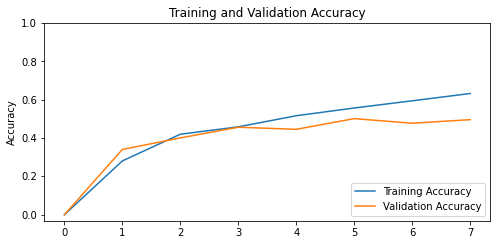

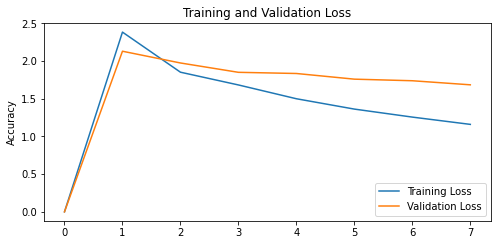

In [18]:
def history_plotter(history):
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    loss = [0.] + history.history['loss']
    val_loss = [0.] + history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title('Training and Validation Loss')

history_plotter(history)

The next step is to develop a model that translates images into numerical values, representing the stats of a Pokémon. Starting from scratch by making another convolutional model would require more time doing model development. Instead, the classification model can be turned into an image encoder by removing the SoftMax layer. Then, the processed image encodings would be used to tune a simple sequential model.  The intuition is that layers early in a convolutional network pickup small and individual edges, and as the information propagates, the network develops these into larger scale or more meaningful pieces of information. So, the last dense layer in the classification model has taken the (128, 128, 3) image and distilled it into 500 factors that suffice to describe the original image.

In [19]:
# Load the trained model and remove the softmax layer to make it into an encoding network
def EncodingModel(TypeModel):

    # Get the pre-trained model and its weights
    directory = os.getcwd() + "\\Model\\TunedModel"
    TypeModel.load_weights(directory)
    
    # Update the model to remove the softmax layer.
    x = TypeModel.layers[-2].output
    
    # Define output & model
    TypeModel = tf.keras.Model(inputs=TypeModel.input, outputs=x)
    
    return TypeModel

EncModel = EncodingModel(TypeModel)
EncModel.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv_11 (TFOpLamb (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract_11 (TFOpLam (None, 128, 128, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 500)               640

In [20]:
def spriteEncoder(pokemonDataFrame,EncModel):

    
    # Cycle through each pokemon, pull its sprite, feed it to the encoding model, and story the output
    for i in range(len(pokemonDataFrame)):
        
        # Define directory
        pokemon = pokemonDataFrame["Pokemon"][i] + ".png"
        directory = os.getcwd() + "\\PokemonSpritesalphabetical\\"
        filepath = directory + pokemon
        
        # Load and format the image
        image = tf.keras.preprocessing.image.load_img(filepath, grayscale=False, color_mode='rgb',interpolation='nearest')
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = np.expand_dims(input_arr, axis=0)
        
        # Process the image with a single forard propagation
        encoding = EncModel.predict(x=input_arr)
        
        # Append the encoding to the X_data array
        if i == 0:
            X_data = np.array(encoding)
        else:
            X_data = np.vstack((X_data, encoding))
    
    # Return the X_Data and the Y_Data
    Y_data = pokemonDataFrame[["HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed"]]

    
    return X_data, Y_data


Now that we have function to handle the encoding, we can develop our input and output data for the stat predictions.

In [21]:
# Create a set of input and output data
X_data, Y_data = spriteEncoder(pokemonDataFrame,EncModel)

# Check dimensions to ensure everything ran correctly
print(X_data.shape)
print(Y_data.shape)

# Develop data in a TF Dataset -- disregarding good practice of train/dev/test splits
Y_data = tf.strings.to_number(Y_data)
statDataset = tf.data.Dataset.from_tensor_slices((X_data, Y_data)).batch(32)

c:\users\patrick\pycharmprojects\pokemonconvolution\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(807, 500)
(807, 6)


For the regression model that handles stat predictions, a simple model with 3 dense layers and dropout will suffice. 


In [22]:
def buildStatModel():

    # Define input
    encoding_shape = (500)
    input_encoding = tf.keras.Input(shape=encoding_shape)
    
    # Add 3 Dense layers with
    x = tf.keras.layers.Dense(100, activation="relu")(input_encoding)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x) 
    
    # Define Output Layer
    predictions = tf.keras.layers.Dense(6)(x)
    
    # Return Model
    statModel = tf.keras.Model(inputs=input_encoding, outputs=predictions)
    
    return statModel

In [23]:
# Build Model
statModel = buildStatModel()

statModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.0001),
                 loss="mse",
                 metrics=["mae"])

statModel.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0  

In [24]:
# Train the model
history = statModel.fit(statDataset, epochs=100)

Epoch 1/100
26/26 [==============================] - 1s 4ms/step - loss: 5692.9751 - mae: 69.8705
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 5618.4238 - mae: 69.3280
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 5495.4502 - mae: 68.4243
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 5282.9170 - mae: 66.8399
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 4930.0093 - mae: 64.0879
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 4358.2100 - mae: 59.2629
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 3530.5923 - mae: 51.6530
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 2561.0020 - mae: 41.5885
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 1832.7047 - mae: 33.7616
Epoch 10/100
26/26 [==============================] - 0s 2ms/step - loss: 1485.2657 - mae: 30.2179
Epoch 11/100
26/26 

26/26 [==============================] - 0s 2ms/step - loss: 979.4714 - mae: 24.1439
Epoch 84/100
26/26 [==============================] - 0s 2ms/step - loss: 962.6593 - mae: 23.8902
Epoch 85/100
26/26 [==============================] - 0s 2ms/step - loss: 980.0212 - mae: 24.1992
Epoch 86/100
26/26 [==============================] - 0s 2ms/step - loss: 973.5050 - mae: 23.9247
Epoch 87/100
26/26 [==============================] - 0s 2ms/step - loss: 948.3623 - mae: 23.8579
Epoch 88/100
26/26 [==============================] - 0s 2ms/step - loss: 963.1877 - mae: 23.7321
Epoch 89/100
26/26 [==============================] - 0s 2ms/step - loss: 940.7811 - mae: 23.5771
Epoch 90/100
26/26 [==============================] - 0s 2ms/step - loss: 996.7581 - mae: 24.4888
Epoch 91/100
26/26 [==============================] - 0s 2ms/step - loss: 964.8376 - mae: 23.9025
Epoch 92/100
26/26 [==============================] - 0s 2ms/step - loss: 950.0927 - mae: 23.6498
Epoch 93/100
26/26 [=============

Putting this all together,  we have a model that takes an image of a Pokémon and predicts its typing and stats. One model handles the image encoding and classification, and the second model leverages the image encoding of the first model to predict its stats.

In [25]:
def predictionChecker(number,pokemonDataFrame, statModel, TypeModel, X_data, Y_data, classNames):

    
    #Retrieve and show Sprite Image
    pokemonDataFrame.iloc[number]
    pokemon = pokemonDataFrame["Pokemon"][number] + ".png"
    directory = os.getcwd() + "\\PokemonSpritesalphabetical\\"
    filepath = directory + pokemon
    image = PIL.Image.open(filepath)
    
    # Load and format the image
    image = tf.keras.preprocessing.image.load_img(filepath, grayscale=False, color_mode='rgb',interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.expand_dims(input_arr, axis=0)
    
    # Predict Type
    typePrediction = TypeModel.predict(input_arr, verbose=0)
    
    # Predict Stats
    input_arr = np.expand_dims(X_data[number,:], axis=0)
    statPrediction = statModel.predict(input_arr)


    #Plot Sprite
    plt.figure(figsize=(7, 7))
    plt.imshow(image)
    plt.axis('off')
    plt.title( pokemonDataFrame["Pokemon"][number] +"'s Sprite")
    
    #Setup Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    fig.suptitle("Model Predictions")
    
    # Plot Type Prediction
    typePred = pd.DataFrame(data=typePrediction.reshape(-1), index=classNames, columns=["Percentage of Confidence"])
    typePred = typePred.sort_values(by="Percentage of Confidence", ascending=True)
    typePred = typePred[14:]
    typePred.plot.barh(ax=ax2)
    plt.title("Correct Type: " + pokemonDataFrame["Type 1"][number])

    
    # Plot Stat Prediction
    indices = ["HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed"]
    actualStats = np.array(Y_data[number,:])
    stats = np.hstack((actualStats.reshape(6,1), statPrediction.reshape(6,1)))
    stats = pd.DataFrame(data=stats, index = indices, columns=["Actual Stats", "Predicted Stats"])
    stats.plot.barh(ax=ax1)

    plt.savefig("figure")


predictionChecker is the bow on top of this project. It will take the Pokedex number of a Pokemon show the model input and outpus.

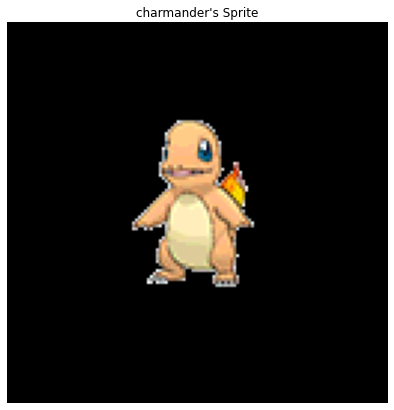

In [ ]:
# Check the prediction of a pokemon
PokedexNumber = 3
predictionChecker(PokedexNumber, pokemonDataFrame, statModel, TypeModel, X_data, Y_data, classNames)